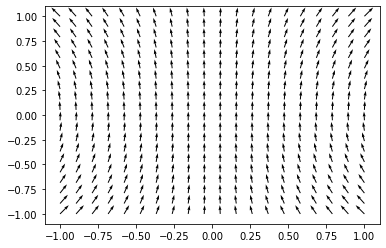

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## VECTOR FIELD 

def f_circle(x,y):
    return np.array([-y/np.sqrt(x**2 + y**2),x/np.sqrt(x**2 + y**2)])

def f_delta(x,y):
    return np.array([x*y,1])

def plot_field(f):
    A,B = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    u,v = f(A,B)
    plt.quiver(A,B,u,v)
    
plot_field(f_delta)

In [2]:
## STATE VARIABLES

T = 25
dt = 0.01
q=1

## NEXT STATE FUNCTION

def next_state(X,f):
    X_new = X.copy()
    X_new[0:2] = X[0:2]+dt*X[2:4]
    X_new[2:4] = X[2:4]+q*f(X[0],X[1])
    return X_new

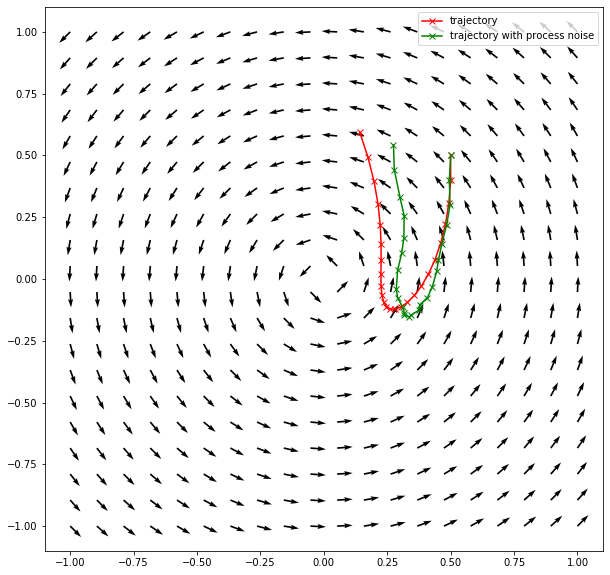

In [3]:
## REAL TRAJECTORY

def trajectory(X0,f=f_circle,T=10,process_noise_std=0):
    """
    X0: initial state
    f: vector field
    T: number of timesteps
    process_noise_std: standard deviation of process noise
    """
    X = np.zeros(shape = (T,4))
    X[0] = X0
    for t in range(1,T):
        X[t] = next_state(X[t-1],f)+process_noise_std*np.random.normal(size=4)
    return X

X0 = np.array([0.5,0.5,0,-10])
X = trajectory(X0, f_circle,T,process_noise_std=0)
X_pn = trajectory(X0, f_circle,T,process_noise_std=0.01)

plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(X_pn[:,0],X_pn[:,1], color ="green",marker="x",label="trajectory with process noise")
plot_field(f_circle)
plt.legend()
plt.show()

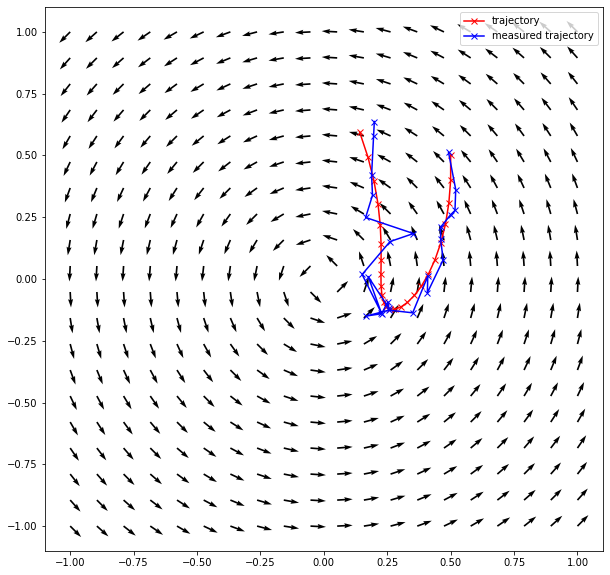

In [4]:
## OBSERVATION MODEL

def observation(X,observation_noise_std=0.05):
    Xn = X.copy()[:,:2]
    Xn = Xn + observation_noise_std*np.random.normal(size=Xn.shape)
    return Xn

Xobs = observation(X)
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Xobs[:,0],Xobs[:,1], color ="blue",marker="x",label="measured trajectory")
plot_field(f_circle)
plt.legend()
plt.show()

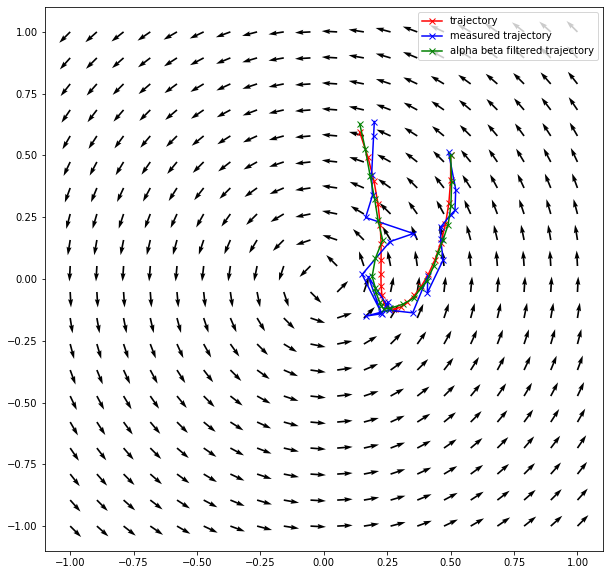

In [5]:
## Alpha Beta FILTER 

def alpha_beta_filter(prev_Xh,new_meas,alpha=0.8,beta=0.2):
    new_X = next_state(prev_Xh.copy(),f_circle)
    new_X[:2] = alpha*new_X[:2]+beta*new_meas
    return new_X

def apply_filter(the_filter,Xobs):
    T,_ = Xobs.shape
    Xfiltered = [X0]
    for t in range(1,T):
        Xfiltered.append(the_filter(*(Xfiltered[-1],Xobs[t])))
    return np.array(Xfiltered)

Xfiltered = apply_filter(alpha_beta_filter,Xobs)

plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.plot(Xobs[:,0],Xobs[:,1], color ="blue",marker="x",label="measured trajectory")
plt.plot(Xfiltered[:,0],Xfiltered[:,1], color ="green",marker="x",label="alpha beta filtered trajectory")
plot_field(f_circle)
plt.legend()
plt.show()

In [6]:
## Extended Kalman Filter

def extended_kalman_filter(prev_Xh,new_meas):
    new_X = next_state(prev_Xh.copy(),f_circle)
    new_X[:2] = alpha*new_X[:2]+beta*new_meas
    return new_X

In [7]:
#Computing position of particle

X = np.zeros(shape = (T,4))
X_noisy = np.zeros(shape = (T,4))
X_filter = np.zeros(shape = (T,4))
X[0] = [-1,-1,5,15]
X_noisy[0] = [-1,-1,5,15]
X_filter[0] = [-1,-1,5,15]
for t in range(1,T):
    X[t] = next_state(X[t-1],f_circle)  #+np.random.normal(scale=0.01) IF DEVIATION
    X_noisy[t] = X[t]+np.random.normal(scale=0.1,size=(4))
    
    #kalman filter
    measurement = X_noisy[t][0:2]
    x_a_priori = next_state(X_filter[t-1],f_circle)
    #innovation = measurement - x_a_priori[0:2]
    #innovation_covariance = np.array([[0.1,0],[0,0.1]])
    #optimal_kalman_gain = np.array([[1,0],[0,1],[0,0],[0,0]]).dot(np.linalg.inv(innovation_covariance))
    x_a_posteriori = x_a_priori.copy()
    x_a_posteriori[0:2] = 0.8*x_a_posteriori[0:2]+0.2*measurement
    #X_filter[t] = x_a_priori+optimal_kalman_gain.dot(innovation)
    X_filter[t]=x_a_posteriori
    
X_noisy = X+np.random.normal(scale=0.1,size =(T,4))

In [8]:
#print(X[:5],"\n noisy \n",X_noisy[:5],"\n filter\n",X_filter[:5])

In [10]:
#Extended Kalman filtering

In [11]:
def next_state(X):
    x,y,v_x,v_y = X_prev

In [12]:
def filter(X_prev):
    """
    INPUT:
    x_prev: previous estimate of state at time t-1
    obs: noisy measurement at time t    
    
    OUTPUT:
    x_next: estimate of the state at time t
    """
    #linearization of f at the previous estimate
    x,y,v_x,v_y = X_prev
    f = (x**2+y**2)**(-3/2)
    A = np.array([
        [1,0,dt,0],
        [0,1,0,dt],
        [x*y/f,-x**2/f,1,0],
        [y**2/f,-x*y/f,0,1]
    ])
    print(X_prev)
    print(A)
    print(A.dot(X_prev))
    return (A.dot(X_prev))
    